In [134]:
# filepath: /home/iwaniukooo/Documents/Projects/biometria-iris/Biometric-Iris-Recognition/iris_pipeline.py

import cv2
import numpy as np
import matplotlib.pyplot as plt

class IrisPipeline:
    def __init__(self, path):
        self.path = path
        self.img_original = None
        self.img_rgb = None
        self.gray = None
        self.binary = None
        self.new_center = None
        self.new_radius = None
        self.average_projection = None
        self.pupil_radius = None
        self.iris_rect = None

    def load_image(self):
        # Load the image and convert it to RGB
        self.img_original = cv2.imread(self.path)
        self.img_rgb = cv2.cvtColor(self.img_original, cv2.COLOR_BGR2RGB)

    def preprocess(self):
        # Convert to grayscale
        self.gray = cv2.cvtColor(self.img_rgb, cv2.COLOR_BGR2GRAY)
        # Binarize to find the pupil
        _, binary_inv = cv2.threshold(self.gray, 30, 255, cv2.THRESH_BINARY_INV)
        # Morphological closing
        kernel_close = np.ones((5,5), np.uint8)
        closed = cv2.morphologyEx(binary_inv, cv2.MORPH_CLOSE, kernel_close, iterations=2)
        # Remove small noise
        kernel_open = np.ones((3,3), np.uint8)
        self.binary = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open, iterations=10)

    def find_pupil(self):
        # Projections to find approximate center
        h, w = self.binary.shape
        vertical_projection = np.sum(self.binary, axis=1)
        horizontal_projection = np.sum(self.binary, axis=0)

        vertical_center = np.argmax(vertical_projection)
        horizontal_center = np.argmax(horizontal_projection)

        # Find the boundary in vertical direction
        for i in range(vertical_center, h):
            if self.binary[i, horizontal_center] == 0:
                v_max_1 = i
                break
        for i in range(vertical_center, -1, -1):
            if self.binary[i, horizontal_center] == 0:
                v_min_1 = i
                break

        # Same for horizontal direction
        for j in range(horizontal_center, w):
            if self.binary[vertical_center, j] == 0:
                h_max_1 = j
                break
        for j in range(horizontal_center, -1, -1):
            if self.binary[vertical_center, j] == 0:
                h_min_1 = j
                break

        # Another way to find final min/max
        vertical_max_freq = vertical_projection[vertical_center]
        horizonal_max_freq = horizontal_projection[horizontal_center]
        v_max, v_min, h_max, h_min = v_max_1, v_min_1, h_max_1, h_min_1

        for j in range(vertical_center, h):
            if vertical_projection[j] < vertical_max_freq * 0.2:
                v_max = j
                break
        for j in range(vertical_center, -1, -1):
            if vertical_projection[j] < vertical_max_freq * 0.2:
                v_min = j
                break
        for j in range(horizontal_center, w):
            if horizontal_projection[j] < horizonal_max_freq * 0.2:
                h_max = j
                break
        for j in range(horizontal_center, -1, -1):
            if horizontal_projection[j] < horizonal_max_freq * 0.2:
                h_min = j
                break

        # Compute radius and center
        self.new_radius = (v_max - v_min + h_max - h_min) // 4
        self.new_center = ((h_max + h_min) // 2, (v_max + v_min) // 2)

    def enhance_image(self):
        # Create mask and set inside circle to white
        mask = np.zeros_like(self.img_rgb)
        cv2.circle(mask, self.new_center, self.new_radius+2, (255,255,255), -1)
        img_with_pupil = self.img_rgb.copy()
        img_with_pupil[mask > 0] = 255
        # Enhance contrast
        alpha = 1.5
        beta = 30
        enhanced_img = cv2.convertScaleAbs(img_with_pupil, alpha=alpha, beta=beta)
        return enhanced_img

    def threshold_and_projection(self, enhanced_img):
        # Use the pupil center and radius calculated in find_pupil
        cx, cy = self.new_center
        r = self.new_radius

        mean_val = self._calculate_mean_on_horizontal_line(enhanced_img, cx, cy, r)
        _, binary_thresh = cv2.threshold(
            enhanced_img,
            min(1.25 * mean_val, 220),
            255,
            cv2.THRESH_BINARY
        )
        kernel2 = np.ones((2,2), np.uint8)
        closing = cv2.morphologyEx(binary_thresh, cv2.MORPH_CLOSE, kernel2, iterations=4)
        gray_bin = cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY)

        angle_start, angle_end = 120, 60
        projection = self._calculate_projection(gray_bin, self.new_center, angle_start, angle_end)
        self.average_projection = int(np.mean(projection))
        return gray_bin


    def _calculate_mean_on_horizontal_line(self, img, cx, cy, r):
        outer_radius = int(1.2 * (r + 2))
        inner_radius = r + 2
        x_min = max(0, cx - outer_radius)
        x_max = min(img.shape[1], cx + outer_radius)
        pixel_values = []
        for x in range(x_min, x_max):
            distance = abs(x - cx)
            if inner_radius < distance <= outer_radius:
                pixel_values.append(img[cy, x])
        return np.mean(pixel_values) if pixel_values else 0

    def _calculate_projection(self, gray_image, center, angle_start, angle_end, num_lines=100):
        h, w = gray_image.shape
        projection = []
        angles = np.linspace(np.radians(angle_start), np.radians(angle_end), num_lines)
        for angle in angles:
            dx = np.cos(angle)
            dy = np.sin(angle)
            line_sum = 0
            for r in range(max(h, w)):
                x = int(center[0] + r * dx)
                y = int(center[1] + r * dy)
                if 0 <= x < w and 0 <= y < h:
                    line_sum += 1 if gray_image[y, x] == 0 else 0
                else:
                    break
            projection.append(line_sum)
        return projection

    def create_rectangular_iris(self):
        # Construct the IrisProcessor-like functionality
        pupil_radius = self.new_radius
        iris_radius = self.new_radius + self.average_projection
        # Ensure grayscale
        if len(self.img_original.shape) > 2:
            working_img = self.img_original[:,:,0]
        else:
            working_img = self.img_original
        self.iris_rect = np.ones((1,1)) # placeholder

        # Create mask for iris
        rows, cols = working_img.shape
        y_grid, x_grid = np.ogrid[:rows, :cols]
        dist_from_center = np.sqrt((x_grid - self.new_center[0])**2 + (y_grid - self.new_center[1])**2)
        mask_iris = (dist_from_center >= pupil_radius) & (dist_from_center <= iris_radius)

        width = int(2 * np.pi * iris_radius)
        height = int(iris_radius - pupil_radius)
        height = max(height, 1)
        self.iris_rect = np.ones((height, width)) * 128

        coords = np.argwhere(mask_iris)
        for y, x in coords:
            r = np.sqrt((x - self.new_center[0])**2 + (y - self.new_center[1])**2)
            dx = (x - self.new_center[0]) / r if r else 0
            dy = (y - self.new_center[1]) / r if r else 0
            theta = np.arctan2(dy, dx)
            if theta < 0: theta += 2*np.pi
            rect_y = int(r - pupil_radius)
            rect_y = max(min(height - 1, rect_y), 0)
            rect_x = int(theta * iris_radius)
            rect_x = max(min(width - 1, rect_x), 0)
            self.iris_rect[rect_y, rect_x] = working_img[y, x]

    def run_pipeline(self):
        self.load_image()
        self.preprocess()
        self.find_pupil()
        enhanced = self.enhance_image()
        self.threshold_and_projection(enhanced)
        self.create_rectangular_iris()
        
    def get_circle_img(self):
        # Draw the pupil circle on the original image
        img_with_circle = self.img_rgb.copy()
        cv2.circle(img_with_circle, self.new_center, self.new_radius, (255, 0, 0), 2)
        cv2.circle(img_with_circle, self.new_center, self.new_radius + self.average_projection, (0, 255, 0), 2)
        return img_with_circle
    
    @staticmethod
    def compare_rectangles(rect_1, rect_2):
        """
        Compare two iris rectangles by resizing them to the same dimensions and calculating MSE.
        
        :param rect_1: First iris rectangle (2D numpy array).
        :param rect_2: Second iris rectangle (2D numpy array).
        :return: Mean Squared Error (MSE) between the two rectangles.
        """
        # Get the dimensions of both rectangles
        height_1, width_1 = rect_1.shape
        height_2, width_2 = rect_2.shape

        # Determine the maximum width and height
        max_height = max(height_1, height_2)
        max_width = max(width_1, width_2)
        
        print(f"Max height: {max_height}, Max width: {max_width}")

        # Function to pad an image to the target size
        def pad_to_size(image, target_height, target_width):
            padded_image = np.full((target_height, target_width), 128, dtype=image.dtype)  # Fill with gray (128)
            padded_image[:image.shape[0], :image.shape[1]] = image
            return padded_image

        # Pad both rectangles to the same size
        rect_1_padded = pad_to_size(rect_1, max_height, max_width)
        rect_2_padded = pad_to_size(rect_2, max_height, max_width)

        # Calculate the Mean Squared Error (MSE)
        mse = np.mean((rect_1_padded - rect_2_padded) ** 2)
        return mse
    @staticmethod
    def compare_rectangles_fourier(rect_1, rect_2):
        """
        Compare two iris rectangles using Fourier Transform similarity.
        :param rect_1: First iris rectangle (2D numpy array).
        :param rect_2: Second iris rectangle (2D numpy array).
        :return: Normalized cross-correlation of Fourier magnitudes.
        """
        # Compute the Fourier Transform of both rectangles
        f1 = np.fft.fft2(rect_1)
        f2 = np.fft.fft2(rect_2)

        # Compute the magnitude spectra
        mag1 = np.abs(f1)
        mag2 = np.abs(f2)

        # Normalize the magnitude spectra
        mag1 = mag1 / np.max(mag1)
        mag2 = mag2 / np.max(mag2)

        # Compute the normalized cross-correlation
        correlation = np.sum(mag1 * mag2) / np.sqrt(np.sum(mag1**2) * np.sum(mag2**2))
        return correlation

    def get_results(self):
        return {
            "pupil_center": self.new_center,
            "pupil_radius": self.new_radius,
            "iris_radius": self.new_radius + self.average_projection,
            "iris_rectangle": self.iris_rect
        }

In [135]:
pipeline_1 = IrisPipeline("data/995/S6995S00.jpg")
pipeline_1.run_pipeline()
results_1 = pipeline_1.get_results()

print("Pupil center:", results_1["pupil_center"])
print("Pupil radius:", results_1["pupil_radius"])
print("Iris radius:", results_1["iris_radius"])

pipeline_2 = IrisPipeline("data/995/S6995S01.jpg")
pipeline_2.run_pipeline()
results_2 = pipeline_2.get_results()

print("Pupil center:", results_2["pupil_center"])
print("Pupil radius:", results_2["pupil_radius"])
print("Iris radius:", results_2["iris_radius"])


Pupil center: (217, 210)
Pupil radius: 44
Iris radius: 95
Pupil center: (218, 211)
Pupil radius: 55
Iris radius: 95


In [136]:
pipeline_foo = IrisPipeline("data/987/S6987S00.jpg")
pipeline_foo.run_pipeline()
results_foo = pipeline_foo.get_results()

print("Pupil center:", results_foo["pupil_center"])
print("Pupil radius:", results_foo["pupil_radius"])
print("Iris radius:", results_foo["iris_radius"])

Pupil center: (249, 319)
Pupil radius: 44
Iris radius: 121


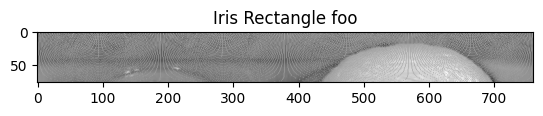

In [137]:
plt.title("Iris Rectangle foo")
plt.imshow(results_foo["iris_rectangle"], cmap='gray')
plt.show()

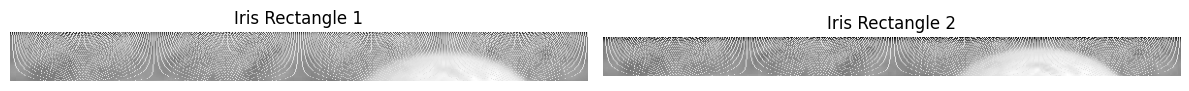

In [138]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Display the first iris rectangle
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.title("Iris Rectangle 1")
plt.imshow(results_1["iris_rectangle"], cmap='gray')
plt.axis('off')  # Turn off axis

# Display the second iris rectangle
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.title("Iris Rectangle 2")
plt.imshow(results_2["iris_rectangle"], cmap='gray')
plt.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

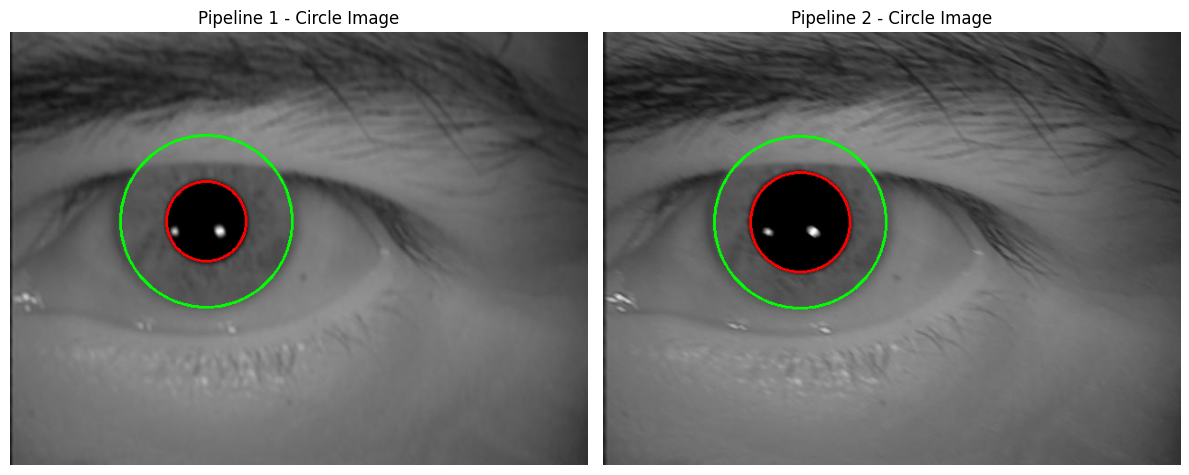

In [139]:
plt.figure(figsize=(12, 6))  # Set the figure size

# Display the first image with the circle
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.title("Pipeline 1 - Circle Image")
plt.imshow(pipeline_1.get_circle_img())
plt.axis('off')  # Turn off axis

# Display the second image with the circle
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.title("Pipeline 2 - Circle Image")
plt.imshow(pipeline_2.get_circle_img())
plt.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [140]:
mse = IrisPipeline.compare_rectangles(results_1["iris_rectangle"], results_2["iris_rectangle"])
print(f"Mean Squared Error (MSE): {mse}")

Max height: 51, Max width: 596
Mean Squared Error (MSE): 1094.917127253586


In [141]:
mse = IrisPipeline.compare_rectangles(results_2["iris_rectangle"], results_foo["iris_rectangle"])
print(f"Mean Squared Error (MSE): {mse}")

Max height: 77, Max width: 760
Mean Squared Error (MSE): 1060.6962064251538


In [142]:
fourier_similarity = IrisPipeline.compare_rectangles_fourier(results_1["iris_rectangle"], results_2["iris_rectangle"])
print(f"Fourier Transform Similarity: {fourier_similarity}")

ValueError: operands could not be broadcast together with shapes (51,596) (40,596) 